# Load Libraries and Helper Function

In [1]:
# load data
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# modelling
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

# cross validation using statsmodel preparation
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold

In [2]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from 
    :return df: <pandas DataFrame> 
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

# Data Cleaning and Preprocessing

### Membaca Data

In [3]:
df = pd.read_csv('student-mat.csv')
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


### Mengecek missing value

In [4]:
#Mengecek null value
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

### Mengecek Duplikat

In [5]:
#Mengecek duplikat
df.duplicated().sum()

0

### Mengeluarkan variabel yang tidak digunakan

In [6]:
#Drop data yang tidak diperlukan
df = df.drop(['address', 'Medu', 'Fedu', 'reason','guardian', 'schoolsup', 'famsup', 'traveltime', 'nursery', 'internet', 'romantic', 'famrel', 'goout', 'Dalc', 'Walc', 'health', 'absences'], axis=1)
df.head()

,school,sex,age,famsize,Pstatus,Mjob,Fjob,studytime,failures,paid,activities,higher,freetime,G1,G2,G3
0,GP,F,18,GT3,A,at_home,teacher,2,0,no,no,yes,3,5,6,6
1,GP,F,17,GT3,T,at_home,other,2,0,no,no,yes,3,5,5,6
2,GP,F,15,LE3,T,at_home,other,2,3,yes,no,yes,3,7,8,10
3,GP,F,15,GT3,T,health,services,3,0,yes,yes,yes,2,15,14,15
4,GP,F,16,GT3,T,other,other,2,0,yes,no,yes,3,6,10,10


### Tipe Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   famsize     395 non-null    object
 4   Pstatus     395 non-null    object
 5   Mjob        395 non-null    object
 6   Fjob        395 non-null    object
 7   studytime   395 non-null    int64 
 8   failures    395 non-null    int64 
 9   paid        395 non-null    object
 10  activities  395 non-null    object
 11  higher      395 non-null    object
 12  freetime    395 non-null    int64 
 13  G1          395 non-null    int64 
 14  G2          395 non-null    int64 
 15  G3          395 non-null    int64 
dtypes: int64(7), object(9)
memory usage: 49.5+ KB


### Mengubah Tipe Data

In [8]:
#Mengubah tipe data
cols = ['school', 'sex', 'famsize', 'Mjob', 'Fjob', 'Pstatus', 'paid', 'activities', 'higher']
df[cols] = df[cols].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      395 non-null    category
 1   sex         395 non-null    category
 2   age         395 non-null    int64   
 3   famsize     395 non-null    category
 4   Pstatus     395 non-null    category
 5   Mjob        395 non-null    category
 6   Fjob        395 non-null    category
 7   studytime   395 non-null    int64   
 8   failures    395 non-null    int64   
 9   paid        395 non-null    category
 10  activities  395 non-null    category
 11  higher      395 non-null    category
 12  freetime    395 non-null    int64   
 13  G1          395 non-null    int64   
 14  G2          395 non-null    int64   
 15  G3          395 non-null    int64   
dtypes: category(9), int64(7)
memory usage: 26.5 KB


# Exploratory Data Analysis

<AxesSubplot:xlabel='school', ylabel='G3'>

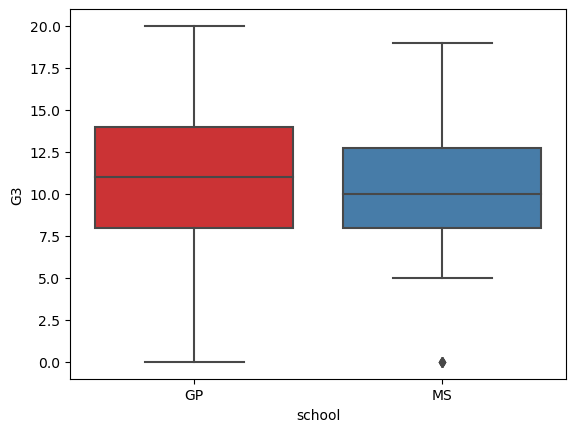

In [9]:
# Kode di bawah bertujuan untuk melihat distribusi dari nilai berdasarkan kategori sekolah dengan menggunakan boxplot.
sns.boxplot(x = "school", y = "G3", data = df, palette="Set1")

<AxesSubplot:xlabel='sex', ylabel='G3'>

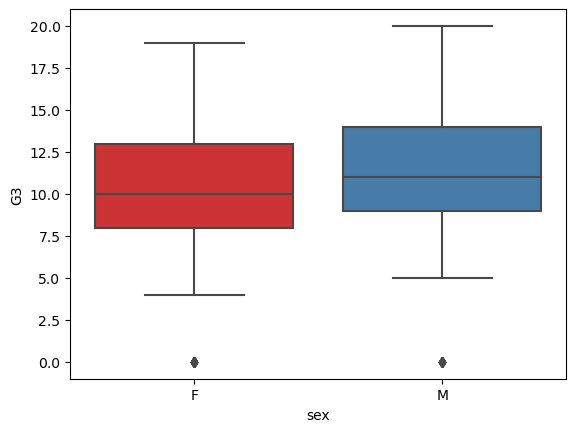

In [10]:
# Kode di bawah bertujuan untuk melihat distribusi dari nilai berdasarkan kategori jenis kelamin dengan menggunakan boxplot.
sns.boxplot(x = "sex", y = "G3", data = df, palette="Set1")

<AxesSubplot:xlabel='famsize', ylabel='G3'>

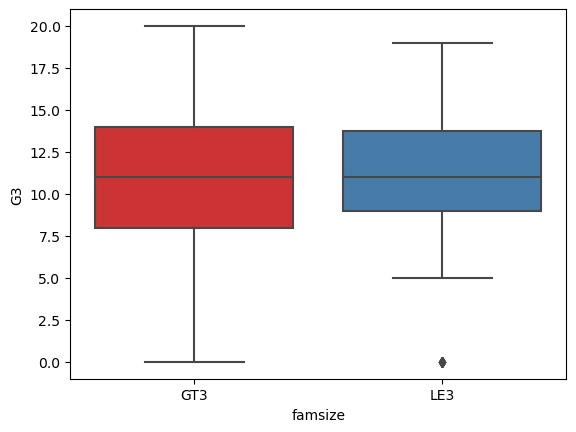

In [11]:
# Kode di bawah bertujuan untuk melihat distribusi dari nilai berdasarkan kategori jumlah anggota keluarga dengan menggunakan boxplot.
sns.boxplot(x = "famsize", y = "G3", data = df, palette="Set1")

<AxesSubplot:xlabel='Pstatus', ylabel='G3'>

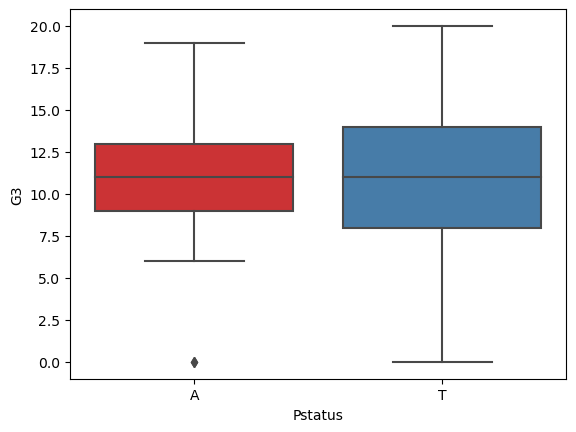

In [12]:
# Kode di bawah bertujuan untuk melihat distribusi dari nilai berdasarkan status orang tua dengan menggunakan boxplot.
sns.boxplot(x = "Pstatus", y = "G3", data = df, palette="Set1")

<AxesSubplot:xlabel='Mjob', ylabel='G3'>

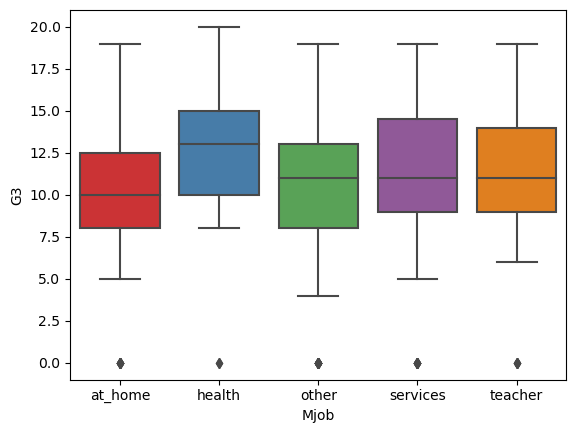

In [13]:
# Kode di bawah bertujuan untuk melihat distribusi dari nilai berdasarkan pekerjaan ibu dengan menggunakan boxplot.
sns.boxplot(x = "Mjob", y = "G3", data = df, palette="Set1")

<AxesSubplot:xlabel='Fjob', ylabel='G3'>

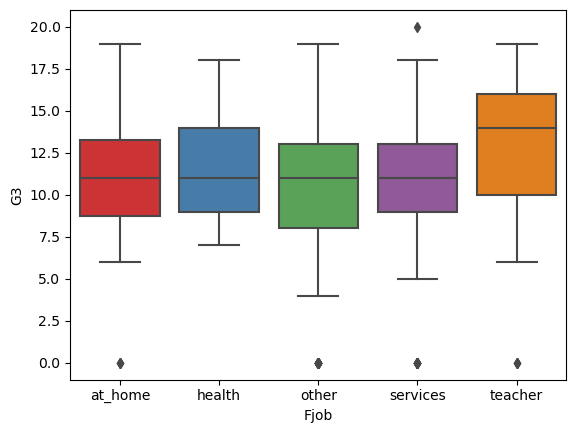

In [14]:
# Kode di bawah bertujuan untuk melihat distribusi dari nilai berdasarkan pekerjaan ayah dengan menggunakan boxplot.
sns.boxplot(x = "Fjob", y = "G3", data = df, palette="Set1")

<AxesSubplot:xlabel='paid', ylabel='G3'>

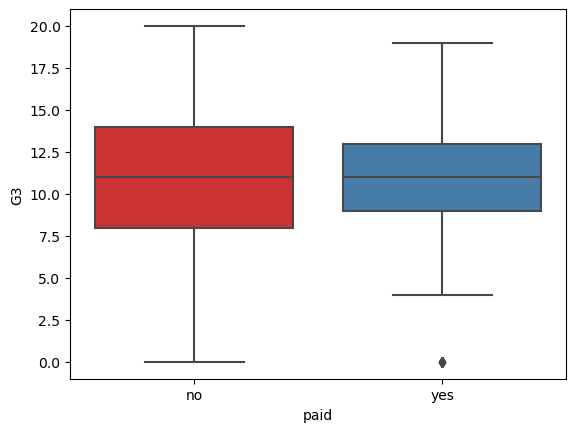

In [15]:
# Kode di bawah bertujuan untuk melihat distribusi dari nilai berdasarkan kategori mengikuti les di luar sekolah dengan menggunakan boxplot.
sns.boxplot(x = "paid", y = "G3", data = df, palette="Set1")

# Uji Statistik

In [16]:
# Import module
from scipy.stats import ttest_ind,levene,kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.diagnostic import normal_ad

### Jenis Kelamin

In [17]:
male = df[df["sex"] == "M"]["G3"] # Membuat variabel untuk kategori laki-laki.
female = df[df["sex"] == "F"]["G3"] # Membuat variabel untuk kategori perempuan.

n_male = male.shape[0] # Menghitung jumlah observasi pada kategori laki-laki.
n_female = female.shape[0] # Menghitung jumlah obsercasi pada kategori perempuan.
result = ttest_ind(male, female, equal_var = True, random_state = 42, alternative= 'greater') # melakukan Uji t.

print(f'Banyak sampel untuk laki-laki = {n_male}')
print(f'Banyak sampel untuk perempuan = {n_female}')
print('='*50)

print('Pertama, menyatakan hipotesis dan taraf signifikansi:')
print('H0 : mu_laki-laki - mu_perempuan <= 0')
print('H1 : mu_laki-laki - mu_perempuan > 0')
print("alpha = 0.05")
print("="*50)

print(f"Statistik Hitung = {result[0]}")
print(f"P Value = {result[1]}")
print("="*50)

print("Kesimpulan :")
print("Berdasarkan hasil uji statistik di atas, nilai p-value yang diperoleh < 0.05 yang berartikan adanya perbedaan rata-rata probabilitas seseorang mendapat nilai lebih tinggi \
antara laki-laki dan perempuan secara signifikan. Oleh karena itu, diperoleh keputusan untuk menolak H0 yang dimana laki-laki memiliki rata-rata probabilitas mendapat nilai \
yang lebih tinggi dibandingkan dengan perempuan.")

Banyak sampel untuk laki-laki = 187
Banyak sampel untuk perempuan = 208
Pertama, menyatakan hipotesis dan taraf signifikansi:
H0 : mu_laki-laki - mu_perempuan <= 0
H1 : mu_laki-laki - mu_perempuan > 0
alpha = 0.05
Statistik Hitung = 2.061992815503971
P Value = 0.019932666170763818
Kesimpulan :
Berdasarkan hasil uji statistik di atas, nilai p-value yang diperoleh < 0.05 yang berartikan adanya perbedaan rata-rata probabilitas seseorang mendapat nilai lebih tinggi antara laki-laki dan perempuan secara signifikan. Oleh karena itu, diperoleh keputusan untuk menolak H0 yang dimana laki-laki memiliki rata-rata probabilitas mendapat nilai yang lebih tinggi dibandingkan dengan perempuan.


### Jenis Sekolah

In [18]:
GP = df[df["school"] == "GP"]["G3"] # Membuat variabel untuk kategori sekolah di Gabriel Pereira .
MS = df[df["school"] == "MS"]["G3"] # Membuat variabel untuk kategori sekolah di Mousinho da Silveira .

n_GP = GP.shape[0] # Menghitung jumlah observasi pada kategori laki-laki.
n_MS = MS.shape[0] # Menghitung jumlah obsercasi pada kategori perempuan.
result = ttest_ind(GP, MS, equal_var = True, random_state = 42, alternative= 'greater') # melakukan Uji t.

print(f'Banyak sampel untuk yang bersekolah di Gabriel Pereira  = {n_GP}')
print(f'Banyak sampel untuk yang bersekolah di Mousinho da Silveira = {n_MS}')
print('='*50)

print('Pertama, menyatakan hipotesis dan taraf signifikansi:')
print('H0 : mu_GP - mu_MS <= 0')
print('H1 : mu_GP - mu_MS > 0')
print("alpha = 0.05")
print("="*50)

print(f"Statistik Hitung = {result[0]}")
print(f"P Value = {result[1]}")
print("="*50)

print("Kesimpulan :")
print("Berdasarkan hasil uji statistik di atas, nilai p-value yang diperoleh < 0.05 yang berartikan adanya perbedaan rata-rata probabilitas seseorang mendapat nilai lebih tinggi \
antara antara yang bersekolah di Gabriel Pereira dengan Mousinho da Silveira secara signifikan. Oleh karena itu, diperoleh keputusan untuk menolak H0 yang dimana yang bersekolah di Gabriel Pereira memiliki rata-rata probabilitas mendapat nilai \
yang lebih tinggi dibandingkan dengan yang bersekolah di Mousinho da Silveira.")

Banyak sampel untuk yang bersekolah di Gabriel Pereira  = 349
Banyak sampel untuk yang bersekolah di Mousinho da Silveira = 46
Pertama, menyatakan hipotesis dan taraf signifikansi:
H0 : mu_GP - mu_MS <= 0
H1 : mu_GP - mu_MS > 0
alpha = 0.05
Statistik Hitung = 0.8933317649161906
P Value = 0.18611311856557344
Kesimpulan :
Berdasarkan hasil uji statistik di atas, nilai p-value yang diperoleh < 0.05 yang berartikan adanya perbedaan rata-rata probabilitas seseorang mendapat nilai lebih tinggi antara antara yang bersekolah di Gabriel Pereira dengan Mousinho da Silveira secara signifikan. Oleh karena itu, diperoleh keputusan untuk menolak H0 yang dimana yang bersekolah di Gabriel Pereira memiliki rata-rata probabilitas mendapat nilai yang lebih tinggi dibandingkan dengan yang bersekolah di Mousinho da Silveira.


### Jumlah Keluarga

In [19]:
GT3 = df[df["famsize"] == "GT3"]["G3"] # Membuat variabel untuk kategori jumlah anggota keluarga kurang dari 3.
LE3 = df[df["famsize"] == "LE3"]["G3"] # Membuat variabel untuk kategori jumlah anggota keluarga lebih dari 3.

n_GT3 = GT3.shape[0] # Menghitung jumlah observasi pada kategori laki-laki.
n_LE3 = LE3.shape[0] # Menghitung jumlah obsercasi pada kategori perempuan.
result = ttest_ind(GT3, LE3, equal_var = True, random_state = 42, alternative= 'greater') # melakukan Uji t.

print(f'Banyak sampel untuk jumlah anggota keluarga kurang dari 3  = {n_LE3}')
print(f'Banyak sampel untuk jumlah anggota keluarga lebih dari 3 = {n_GT3}')
print('='*50)

print('Pertama, menyatakan hipotesis dan taraf signifikansi:')
print('H0 : mu_LE3 - mu_GT3 <= 0')
print('H1 : mu_LE3 - mu_GT3 > 0')
print("alpha = 0.05")
print("="*50)

print(f"Statistik Hitung = {result[0]}")
print(f"P Value = {result[1]}")
print("="*50)

print("Kesimpulan :")
print("Berdasarkan hasil uji statistik di atas, nilai p-value yang diperoleh < 0.05 yang berartikan adanya perbedaan rata-rata probabilitas seseorang mendapat nilai lebih tinggi \
antara seseorang dengan jumlah anggota keluarga kurang dari 3 dengan jumlah anggota keluarga lebih dari 3 secara signifikan. Oleh karena itu, diperoleh keputusan untuk menolak H0 yang dimana yang memiliki jumlah anggota keluarga kurang dari 3 memiliki rata-rata probabilitas mendapat nilai \
yang lebih tinggi dibandingkan dengan yang memiliki jumlah anggota keluarga lebih dari 3.")

Banyak sampel untuk jumlah anggota keluarga kurang dari 3  = 114
Banyak sampel untuk jumlah anggota keluarga lebih dari 3 = 281
Pertama, menyatakan hipotesis dan taraf signifikansi:
H0 : mu_LE3 - mu_GT3 <= 0
H1 : mu_LE3 - mu_GT3 > 0
alpha = 0.05
Statistik Hitung = -1.6192073299128047
P Value = 0.9468975860807022
Kesimpulan :
Berdasarkan hasil uji statistik di atas, nilai p-value yang diperoleh < 0.05 yang berartikan adanya perbedaan rata-rata probabilitas seseorang mendapat nilai lebih tinggi antara seseorang dengan jumlah anggota keluarga kurang dari 3 dengan jumlah anggota keluarga lebih dari 3 secara signifikan. Oleh karena itu, diperoleh keputusan untuk menolak H0 yang dimana yang memiliki jumlah anggota keluarga kurang dari 3 memiliki rata-rata probabilitas mendapat nilai yang lebih tinggi dibandingkan dengan yang memiliki jumlah anggota keluarga lebih dari 3.


### Status Orang Tua

In [20]:
T = df[df["Pstatus"] == "T"]["G3"] # Membuat variabel untuk kategori orang tua yang tinggal bersama.
A = df[df["Pstatus"] == "A"]["G3"] # Membuat variabel untuk kategori orang tua yang berpisah.

n_T = T.shape[0] # Menghitung jumlah observasi pada kategori laki-laki.
n_A = A.shape[0] # Menghitung jumlah obsercasi pada kategori perempuan.
result = ttest_ind(T, A, equal_var = True, random_state = 42, alternative= 'greater') # melakukan Uji t.

print(f'Banyak sampel untuk orang tua yang tinggal bersama  = {n_T}')
print(f'Banyak sampel untuk orang tua yang berpisah = {n_A}')
print('='*50)

print('Pertama, menyatakan hipotesis dan taraf signifikansi:')
print('H0 : mu_tinggal_bersama - mu_berpisah <= 0')
print('H1 : mu_tinggal_bersama - mu_berpisah > 0')
print("alpha = 0.05")
print("="*50)

print(f"Statistik Hitung = {result[0]}")
print(f"P Value = {result[1]}")
print("="*50)

print("Kesimpulan :")
print("Berdasarkan hasil uji statistik di atas, nilai p-value yang diperoleh < 0.05 yang berartikan adanya perbedaan rata-rata probabilitas seseorang mendapat nilai lebih tinggi \
antara seseorang dengan orang tua yang lengkap dengan orang tua yang berpisah secara signifikan. Oleh karena itu, diperoleh keputusan untuk menolak H0 yang dimana yang memiliki orang tua lengkap memiliki rata-rata probabilitas mendapat nilai \
yang lebih tinggi dibandingkan dengan yang memiliki orang tua yang berpisah.")

Banyak sampel untuk orang tua yang tinggal bersama  = 354
Banyak sampel untuk orang tua yang berpisah = 41
Pertama, menyatakan hipotesis dan taraf signifikansi:
H0 : mu_tinggal_bersama - mu_berpisah <= 0
H1 : mu_tinggal_bersama - mu_berpisah > 0
alpha = 0.05
Statistik Hitung = -1.1519230889779004
P Value = 0.8749735303680415
Kesimpulan :
Berdasarkan hasil uji statistik di atas, nilai p-value yang diperoleh < 0.05 yang berartikan adanya perbedaan rata-rata probabilitas seseorang mendapat nilai lebih tinggi antara seseorang dengan orang tua yang lengkap dengan orang tua yang berpisah secara signifikan. Oleh karena itu, diperoleh keputusan untuk menolak H0 yang dimana yang memiliki orang tua lengkap memiliki rata-rata probabilitas mendapat nilai yang lebih tinggi dibandingkan dengan yang memiliki orang tua yang berpisah.


### Jenis Pekerjaan Ibu

In [21]:
# Kode di bawah ini bertujuan untuk melakukan uji ANOVA pada pengaruh jenis pekerjaan ibu
print("Pertama, menyatakan hipotesis dan taraf signifikansi :")
print("H0 : mu_at_home = mu_health = mu_other mJob = mu_services = mu_teacher")
print("H1 : Setidaknya terdapat satu yang berbeda")
print("Alpha = 0.05")

model_sampo = ols('G3 ~ Mjob', data = df).fit() # Membuat persamaan linear antara nilai dengan variabel Mjob.
aov_table_1 = sm.stats.anova_lm(model_sampo) # Melakuakn uji ANOVA.

print("="*50)

print("Hasil dari Uji ANOVA :")
print(aov_table_1)
print("="*50)

print("Kesimpulan :")
print("Karena hasil uji ANOVA menyatakan p-value > 0.05, maka keputusan yang diperoleh adalah gagal untuk menolak H0 yang dimana tidak adanya perbedaan rata - rata probabilitas seseorang \
mendapat nilai yang lebih tinggi yang signifkan dengan pekerjaan Ibunya" )

Pertama, menyatakan hipotesis dan taraf signifikansi :
H0 : mu_at_home = mu_health = mu_other mJob = mu_services = mu_teacher
H1 : Setidaknya terdapat satu yang berbeda
Alpha = 0.05
Hasil dari Uji ANOVA :
             df       sum_sq    mean_sq        F    PR(>F)
Mjob        4.0   306.643668  76.660917  3.75446  0.005195
Residual  390.0  7963.265193  20.418629      NaN       NaN
Kesimpulan :
Karena hasil uji ANOVA menyatakan p-value > 0.05, maka keputusan yang diperoleh adalah gagal untuk menolak H0 yang dimana tidak adanya perbedaan rata - rata probabilitas seseorang mendapat nilai yang lebih tinggi yang signifkan dengan pekerjaan Ibunya


### Jenis Pekerjaan Ayah

In [22]:
# Kode di bawah ini bertujuan untuk melakukan uji ANOVA pada pengaruh jenis pekerjaan ayah
print("Pertama, menyatakan hipotesis dan taraf signifikansi :")
print("H0 : mu_at_home = mu_health = mu_other Fjob = mu_services = mu_teacher")
print("H1 : Setidaknya terdapat satu yang berbeda")
print("Alpha = 0.05")

model_sampo = ols('G3 ~ Fjob', data = df).fit() # Membuat persamaan linear antara nilai dengan variabel Fjob.
aov_table_1 = sm.stats.anova_lm(model_sampo) # Melakuakn uji ANOVA.

print("="*50)

print("Hasil dari Uji ANOVA :")
print(aov_table_1)
print("="*50)

print("Kesimpulan :")
print("Karena hasil uji ANOVA menyatakan p-value > 0.05, maka keputusan yang diperoleh adalah gagal untuk menolak H0 yang dimana tidak adanya perbedaan rata - rata probabilitas seseorang \
mendapat nilai yang lebih tinggi yang signifkan dengan pekerjaan Ayahnya" )

Pertama, menyatakan hipotesis dan taraf signifikansi :
H0 : mu_at_home = mu_health = mu_other Fjob = mu_services = mu_teacher
H1 : Setidaknya terdapat satu yang berbeda
Alpha = 0.05
Hasil dari Uji ANOVA :
             df       sum_sq    mean_sq         F    PR(>F)
Fjob        4.0   109.055409  27.263852  1.302915  0.268314
Residual  390.0  8160.853452  20.925265       NaN       NaN
Kesimpulan :
Karena hasil uji ANOVA menyatakan p-value > 0.05, maka keputusan yang diperoleh adalah gagal untuk menolak H0 yang dimana tidak adanya perbedaan rata - rata probabilitas seseorang mendapat nilai yang lebih tinggi yang signifkan dengan pekerjaan Ayahnya


### Status mengikuti les di luar kelas

In [23]:
yes = df[df["paid"] == "yes"]["G3"] # Membuat variabel untuk kategori mengikuti les di luar kelas.
no = df[df["paid"] == "no"]["G3"] # Membuat variabel untuk kategori tidak mengikuti les di luar kelas.

n_yes = GT3.shape[0] # Menghitung jumlah observasi pada kategori laki-laki.
n_no = LE3.shape[0] # Menghitung jumlah obsercasi pada kategori perempuan.
result = ttest_ind(yes, no, equal_var = True, random_state = 42, alternative= 'greater') # melakukan Uji t.

print(f'Banyak sampel untuk murid yang mengikuti les di luar kelas  = {n_yes}')
print(f'Banyak sampel untuk murid yang tidak mengikuti les di luar kelas = {n_no}')
print('='*50)

print('Pertama, menyatakan hipotesis dan taraf signifikansi:')
print('H0 : mu_yes - mu_no <= 0')
print('H1 : mu_yes - mu_no > 0')
print("alpha = 0.05")
print("="*50)

print(f"Statistik Hitung = {result[0]}")
print(f"P Value = {result[1]}")
print("="*50)

print("Kesimpulan :")
print("Berdasarkan hasil uji statistik di atas, nilai p-value yang diperoleh < 0.05 yang berartikan adanya perbedaan rata-rata probabilitas seseorang mendapat nilai lebih tinggi \
antara murid yang mengikuti les di luar kelas dengan murid yang tidak mengikuti les di luar kelas secara signifikan. Oleh karena itu, diperoleh keputusan untuk menolak H0 yang dimana murid yang mengikuti les di luar kelas memiliki rata-rata probabilitas mendapat nilai \
yang lebih tinggi dibandingkan dengan murid yang tidak mengikuti les di luar kelas.")

Banyak sampel untuk murid yang mengikuti les di luar kelas  = 281
Banyak sampel untuk murid yang tidak mengikuti les di luar kelas = 114
Pertama, menyatakan hipotesis dan taraf signifikansi:
H0 : mu_yes - mu_no <= 0
H1 : mu_yes - mu_no > 0
alpha = 0.05
Statistik Hitung = 2.0325971231028626
P Value = 0.021382532016787765
Kesimpulan :
Berdasarkan hasil uji statistik di atas, nilai p-value yang diperoleh < 0.05 yang berartikan adanya perbedaan rata-rata probabilitas seseorang mendapat nilai lebih tinggi antara murid yang mengikuti les di luar kelas dengan murid yang tidak mengikuti les di luar kelas secara signifikan. Oleh karena itu, diperoleh keputusan untuk menolak H0 yang dimana murid yang mengikuti les di luar kelas memiliki rata-rata probabilitas mendapat nilai yang lebih tinggi dibandingkan dengan murid yang tidak mengikuti les di luar kelas.


### Numerical Variabels

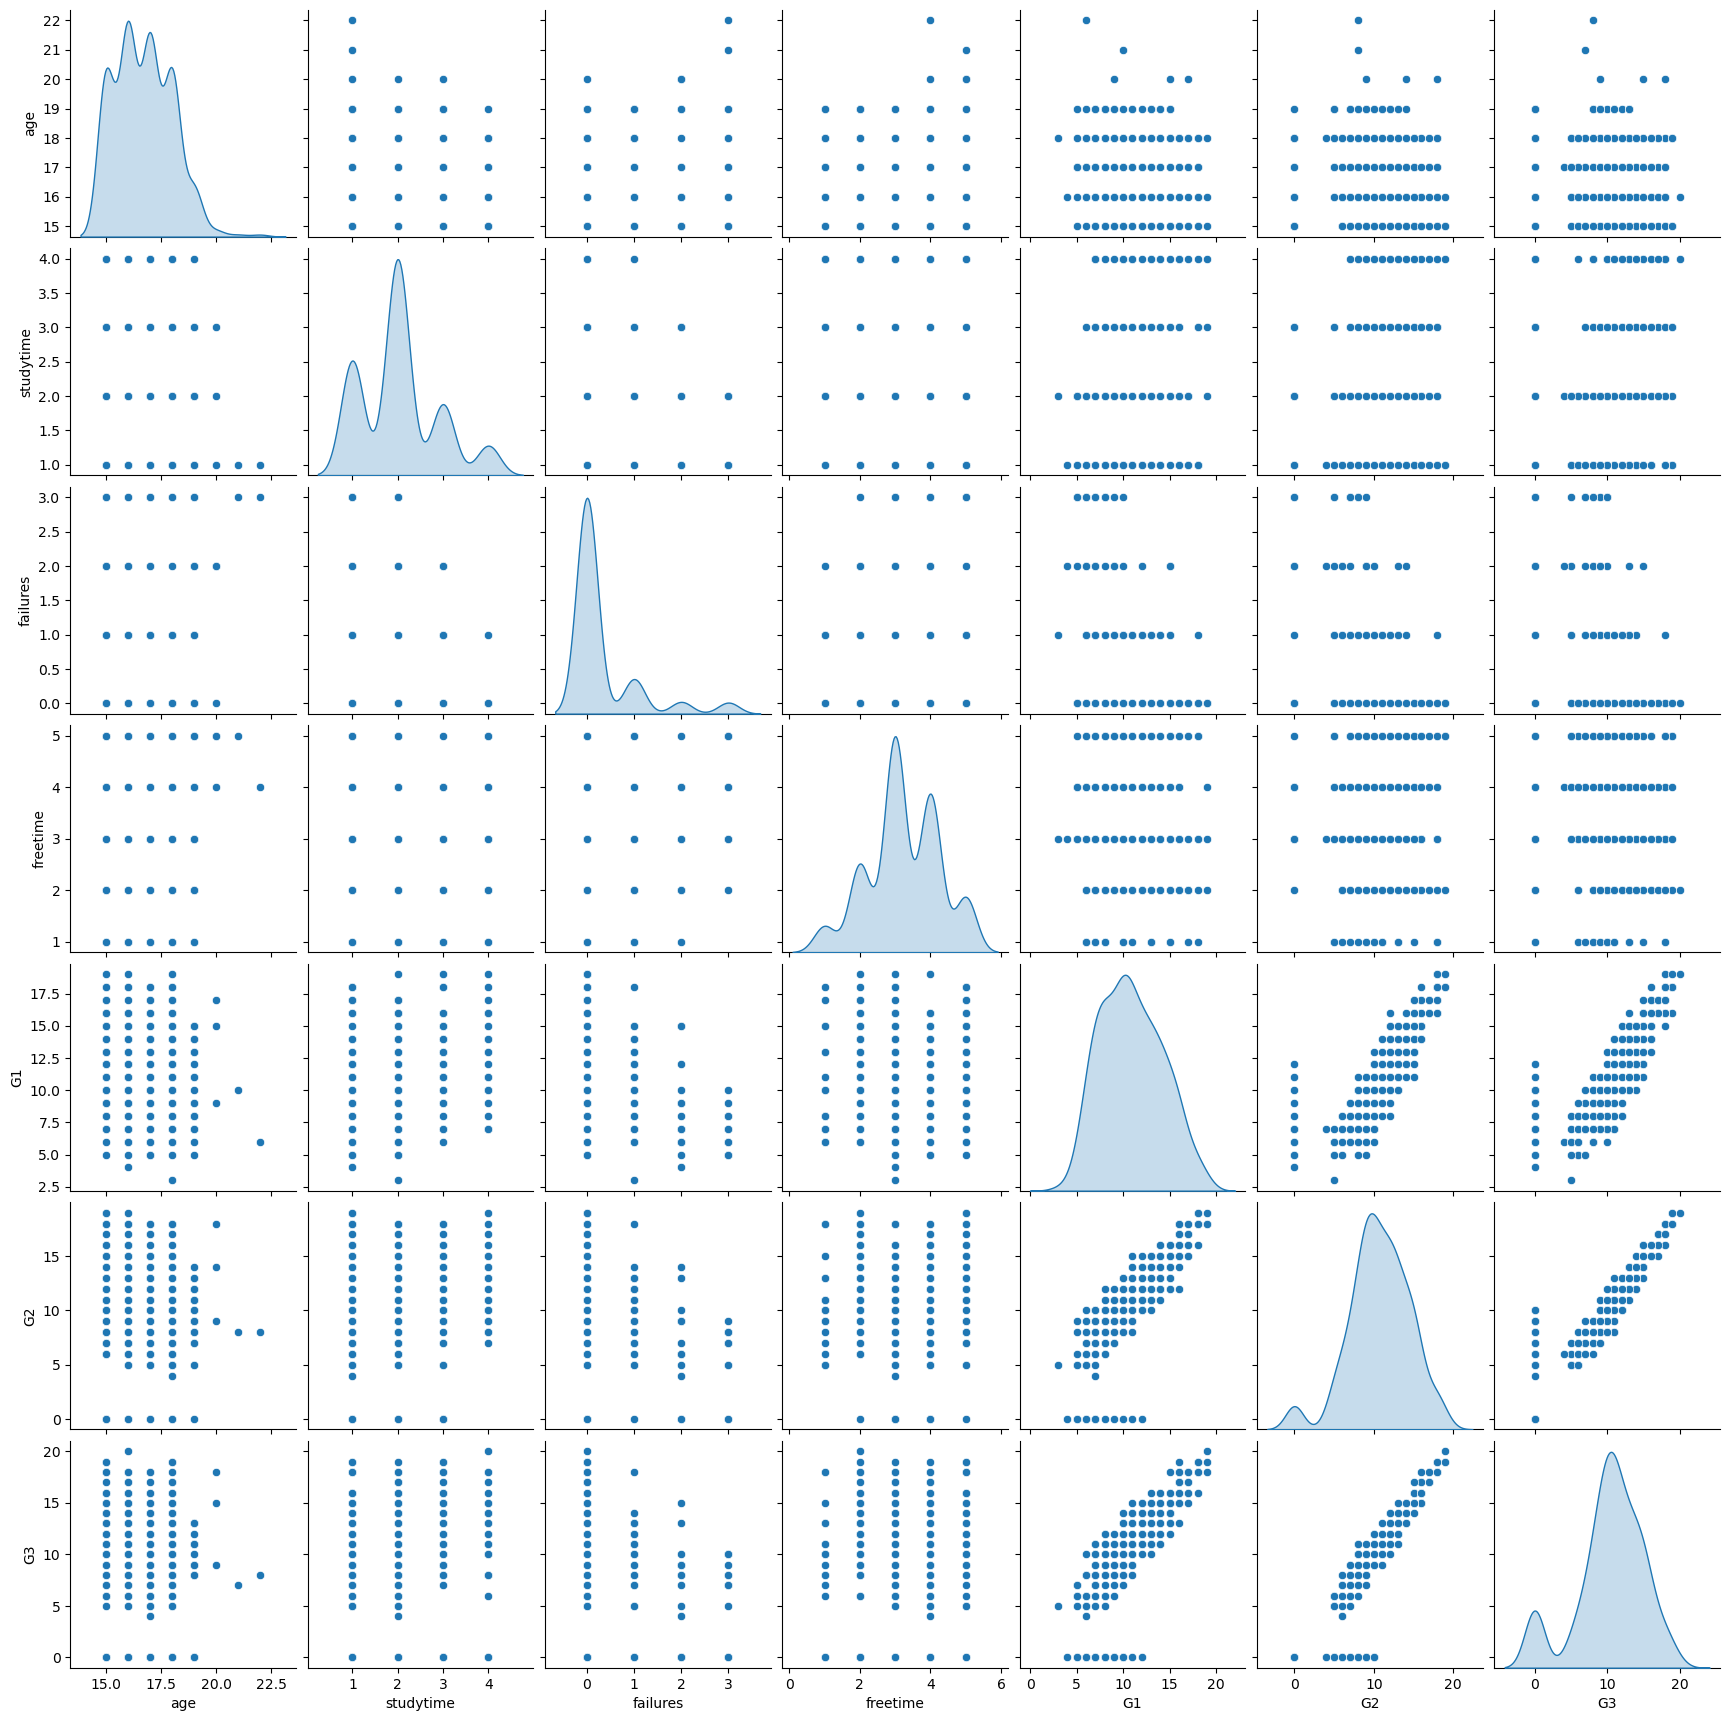

In [24]:
# Kode di bawah bertujuan untuk memvisualisasikan interaksi antara bebera features dengan meggunakan scatter plot dan kde plot.
columns_ = ["age", "studytime", "failures", "freetime", "G1", "G2", "G3"]
sns.pairplot(df[columns_], diag_kind = 'kde')
plt.show()

## Correlation Analysis

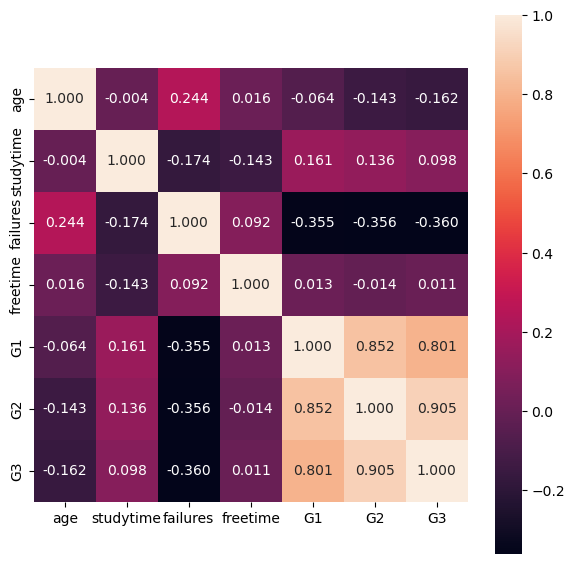

In [25]:
# Kode di bawah untuk melihat korelasi antar features.
corr_ = df[columns_].corr()
plt.figure(figsize = (7,7))
sns.heatmap(corr_, fmt= ".3f", annot= True,square= True)
plt.show()

# Building Regression Model

In [26]:
df

,school,sex,age,famsize,Pstatus,Mjob,Fjob,studytime,failures,paid,activities,higher,freetime,G1,G2,G3
0,GP,F,18,GT3,A,at_home,teacher,2,0,no,no,yes,3,5,6,6
1,GP,F,17,GT3,T,at_home,other,2,0,no,no,yes,3,5,5,6
2,GP,F,15,LE3,T,at_home,other,2,3,yes,no,yes,3,7,8,10
3,GP,F,15,GT3,T,health,services,3,0,yes,yes,yes,2,15,14,15
4,GP,F,16,GT3,T,other,other,2,0,yes,no,yes,3,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,LE3,A,services,services,2,2,yes,no,yes,5,9,9,9
391,MS,M,17,LE3,T,services,services,1,0,no,no,yes,4,14,16,16
392,MS,M,21,GT3,T,other,other,1,3,no,no,yes,5,10,8,7
393,MS,M,18,LE3,T,services,other,1,0,no,no,yes,4,11,12,10


### Mengeluarkan variabel yang tidak memberikan efek signifikan terhadap G3

In [27]:
# Exclude variabel-variabel yang tidak memberikan efek signifikan terhadap G3
df.drop(['age', 'studytime', 'freetime', 'activities', 'higher'], axis=1, inplace = True)
df

,school,sex,famsize,Pstatus,Mjob,Fjob,failures,paid,G1,G2,G3
0,GP,F,GT3,A,at_home,teacher,0,no,5,6,6
1,GP,F,GT3,T,at_home,other,0,no,5,5,6
2,GP,F,LE3,T,at_home,other,3,yes,7,8,10
3,GP,F,GT3,T,health,services,0,yes,15,14,15
4,GP,F,GT3,T,other,other,0,yes,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,LE3,A,services,services,2,yes,9,9,9
391,MS,M,LE3,T,services,services,0,no,14,16,16
392,MS,M,GT3,T,other,other,3,no,10,8,7
393,MS,M,LE3,T,services,other,0,no,11,12,10


### Convert some variabels into binary

In [28]:
# Use LabelEncoder to convert the Pstatus and paid variable into numeric
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder Object and transform the Pstatus and paid variable
df["Pstatus"] = LabelEncoder().fit_transform(df["Pstatus"])
df["paid"] = LabelEncoder().fit_transform(df["paid"])
df["sex"] = LabelEncoder().fit_transform(df["sex"])
df.head()

,school,sex,famsize,Pstatus,Mjob,Fjob,failures,paid,G1,G2,G3
0,GP,0,GT3,0,at_home,teacher,0,0,5,6,6
1,GP,0,GT3,1,at_home,other,0,0,5,5,6
2,GP,0,LE3,1,at_home,other,3,1,7,8,10
3,GP,0,GT3,1,health,services,0,1,15,14,15
4,GP,0,GT3,1,other,other,0,1,6,10,10


In [29]:
class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param data: <pandas DataFrame> 
    :param n_fold: <int> Number of fold in k-fold CV
    :return fold_train: <pandas DataFrame> Training Data
    :return fold_test: <pandas DataFrame> Testing Data
    """
    kfold = KFold(n_splits = n_fold, 
                  shuffle = True, 
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
        
    return (fold_train, fold_test)

## Evaluate a model using K-fold cross validation

In [30]:
# Create a class model
ols_all_pred = StatsmodelsRegressor(smf.ols, "G3 ~ school + sex + famsize + Pstatus + Mjob + Fjob + failures + paid + G1 + G2")

# Create k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

scores_ols_all_pred = cross_val_score(estimator = ols_all_pred,
                                       X = df,
                                       y = df["G3"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, 
                                    columns=["test_rsquared"])
scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.836166,Folds 1
1,0.784702,Folds 2
2,0.829680,Folds 3
3,0.788347,Folds 4
4,0.806959,Folds 5


In [31]:
scores_ols_all_pred["test_rsquared"].mean()

0.8091705624975267

The model use all media have good fit, it can explain 80.92% variance of salary. Let's build the model using whole data to infer the estimated coefficient from the model, and gain the insight from business prespective

## Fit Linear Regression - Using All Predictors

In [32]:
# Create OLS model object
model = smf.ols("G3 ~ school + sex + famsize + Pstatus + Mjob + Fjob + failures + paid + G1 + G2", df)

# Fit the model
results_model_G3 = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_G3 = print_coef_std_err(results_model_G3)
results_G3

,coef,std err
Intercept,-1.757218,0.701163
school[T.MS],0.110904,0.312522
famsize[T.LE3],0.017126,0.223434
Mjob[T.health],-0.036540,0.437405
Mjob[T.other],0.100525,0.310963
Mjob[T.services],0.229394,0.329910
Mjob[T.teacher],0.061675,0.387656
Fjob[T.health],0.735147,0.651993
Fjob[T.other],0.360474,0.467221
Fjob[T.services],-0.019338,0.484948


Nilai intercept negatif sehingga kurang bermakna.

In [33]:
#Alternative way using one hot encoding
encoded_df = pd.get_dummies(data = df, columns = ['school', 'sex', 'famsize'])
encoded_df

,Pstatus,Mjob,Fjob,failures,paid,G1,G2,G3,school_GP,school_MS,sex_0,sex_1,famsize_GT3,famsize_LE3
0,0,at_home,teacher,0,0,5,6,6,1,0,1,0,1,0
1,1,at_home,other,0,0,5,5,6,1,0,1,0,1,0
2,1,at_home,other,3,1,7,8,10,1,0,1,0,0,1
3,1,health,services,0,1,15,14,15,1,0,1,0,1,0
4,1,other,other,0,1,6,10,10,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0,services,services,2,1,9,9,9,0,1,0,1,0,1
391,1,services,services,0,0,14,16,16,0,1,0,1,0,1
392,1,other,other,3,0,10,8,7,0,1,0,1,1,0
393,1,services,other,0,0,11,12,10,0,1,0,1,0,1


## Centering Predictors

Centering dilakukan agar interpretasi hasil regresi lebih baik.

In [34]:
mean_G1= encoded_df["G1"].mean()
mean_G1 = np.round(mean_G1,0)

mean_G1

11.0

In [35]:
mean_G2= encoded_df["G2"].mean()
mean_G2 = np.round(mean_G2,0)

mean_G2

11.0

In [36]:
encoded_df["G1"] = encoded_df["G1"]-mean_G1
encoded_df.rename(columns = {"G1":"G1Centered"}, inplace=True)
encoded_df.head()

,Pstatus,Mjob,Fjob,failures,paid,G1Centered,G2,G3,school_GP,school_MS,sex_0,sex_1,famsize_GT3,famsize_LE3
0,0,at_home,teacher,0,0,-6.0,6,6,1,0,1,0,1,0
1,1,at_home,other,0,0,-6.0,5,6,1,0,1,0,1,0
2,1,at_home,other,3,1,-4.0,8,10,1,0,1,0,0,1
3,1,health,services,0,1,4.0,14,15,1,0,1,0,1,0
4,1,other,other,0,1,-5.0,10,10,1,0,1,0,1,0


In [37]:
encoded_df["G2"] = encoded_df["G2"]-mean_G2
encoded_df.rename(columns = {"G2":"G2Centered"}, inplace=True)
encoded_df.head()

,Pstatus,Mjob,Fjob,failures,paid,G1Centered,G2Centered,G3,school_GP,school_MS,sex_0,sex_1,famsize_GT3,famsize_LE3
0,0,at_home,teacher,0,0,-6.0,-5.0,6,1,0,1,0,1,0
1,1,at_home,other,0,0,-6.0,-6.0,6,1,0,1,0,1,0
2,1,at_home,other,3,1,-4.0,-3.0,10,1,0,1,0,0,1
3,1,health,services,0,1,4.0,3.0,15,1,0,1,0,1,0
4,1,other,other,0,1,-5.0,-1.0,10,1,0,1,0,1,0


In [38]:
# Create a class model
ols_all_pred = StatsmodelsRegressor(smf.ols, "G3 ~ Pstatus + Mjob + Fjob + failures + paid + G1Centered + G2Centered + school_GP + school_MS + sex_0 + sex_1 + famsize_GT3 + famsize_LE3")

# Create k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

scores_ols_all_pred = cross_val_score(estimator = ols_all_pred,
                                       X = encoded_df,
                                       y = encoded_df["G3"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, 
                                    columns=["test_rsquared"])
scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.836166,Folds 1
1,0.784702,Folds 2
2,0.829680,Folds 3
3,0.788347,Folds 4
4,0.806959,Folds 5


In [39]:
scores_ols_all_pred["test_rsquared"].mean()

0.8091705624975265

The model use all media have good fit, it can explain 80.92% variance of salary. Let's build the model using whole data to infer the estimated coefficient from the model, and gain the insight from business prespective

In [40]:
# Create OLS model object
model = smf.ols("G3 ~ Pstatus + Mjob + Fjob + failures + paid + G1Centered + G2Centered + school_GP + school_MS + sex_0 + sex_1 + famsize_GT3 + famsize_LE3", encoded_df)

# Fit the model
results_model_G3 = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_G3 = print_coef_std_err(results_model_G3)
results_G3

,coef,std err
Intercept,4.291079,0.232397
Mjob[T.health],-0.036540,0.437405
Mjob[T.other],0.100525,0.310963
Mjob[T.services],0.229394,0.329910
Mjob[T.teacher],0.061675,0.387656
Fjob[T.health],0.735147,0.651993
Fjob[T.other],0.360474,0.467221
Fjob[T.services],-0.019338,0.484948
Fjob[T.teacher],0.172361,0.583511
Pstatus,-0.304496,0.330166


### G3 = 4.29 - 0.04 x Mjob(health) + 0.1 x Mjob(other) + 0.23 x Mjob(services) + 0.06 Mjob(teacher) + 0.74 Fjob(health) + 0.36 x Fjob(other) - 0.02 x Fjob(services) + 0.12 x Fjob(teacher) - 0.3 x Pstatus - 0.23 x failures + 0.09 x paid + 0.15 x (G1 - 11) + 0.98 x (G2 - 11) + 2.1 x school_GP + 2.2 x school_MS + 2.04 x sex_0 + 2.25 x sex_1 + 2.14 x famsize_GT3 + 2.15 x famsize_LE3

#### Interpretasi Jenis Pekerjaan Ibu

Jika membandingkan dua orang dengan jenis pekerjaan ayah, status orang tua, pernah gagal atau tidak, mengikuti les diluar kelas atau tidak, nilai G1, nilai G2, jenis kelamin, sekolah, dan jumlah anggota keluarga yang sama, nilai siswa di kelas 3 dengan jenis pekerjaan ibu-nya adalah dibidang kesehatan diperkirakan lebih rendah 0.04 poin. Jika pekerjaan ibu dari siswa tersebut dibidang lainnya diperkirakan lebih tinggi 0.1 poin, jika dibidang services maka diperkirakan lebih tinggi 0.23 poin, dan jika sebagai guru maka diperkirakan lebih tinggi 0.06 poin.

#### Interpretasi Jenis Pekerjaan Ayah

Jika membandingkan dua orang dengan jenis pekerjaan ibu, status orang tua, pernah gagal atau tidak, mengikuti les diluar kelas atau tidak, nilai G1, nilai G2, jenis kelamin, sekolah, dan jumlah anggota keluarga yang sama, nilai siswa di kelas 3 dengan jenis pekerjaan ayah-nya adalah dibidang kesehatan diperkirakan lebih tinggi 0.74 poin. Jika pekerjaan ayah dari siswa tersebut dibidang lainnya diperkirakan lebih tinggi 0.36 poin, jika dibidang services maka diperkirakan lebih tinggi 0.02 poin, dan jika sebagai guru maka diperkirakan lebih tinggi 0.12 poin.

#### Interpretasi Status Orang Tua

Jika membandingkan dua orang dengan jenis pekerjaan ibu, jenis pekerjaan ayah, pernah gagal atau tidak, mengikuti les diluar kelas atau tidak, nilai G1, nilai G2, jenis kelamin, sekolah, dan jumlah anggota keluarga yang sama, selisih nilai siswa di kelas 3 dengan status orang tua-nya sudah berpisah dibandingkan jika orang tua dari siswa tersebut masih bersama adalah sebesar 0.3.

#### Interpretasi Pernah Gagal di Kelas Sebelumnya

Jika membandingkan dua orang dengan jenis pekerjaan ibu, jenis pekerjaan ayah, status orang tua, mengikuti les diluar kelas atau tidak, nilai G1, nilai G2, jenis kelamin, sekolah, dan jumlah anggota keluarga yang sama, selisih nilai siswa di kelas 3 jika siswa tersebut di kelas sebelumnya pernah gagal atau tidak adalah sebesar 0.23.

#### Interpretasi Mengikuti Kegiatan Les di luar Kelas

Jika membandingkan dua orang dengan jenis pekerjaan ibu, jenis pekerjaan ayah, status orang tua, pernah gagal atau tidak, nilai G1, nilai G2 yang sama, jenis kelamin, sekolah, dan jumlah anggota keluarga, selisih nilai siswa di kelas 3 jika siswa tersebut mengikuti les diluar kelas atau tidak adalah sebesar 0.09.

#### Interpretasi Nilai G1

Jika membandingkan dua orang dengan jenis pekerjaan ibu, jenis pekerjaan ayah, status orang tua, pernah gagal atau tidak, mengikuti les diluar kelas atau tidak, nilai G2, jenis kelamin, sekolah, dan jumlah anggota keluarga yang sama, seseorang dengan nilai saat kelas 1 lebih tinggi 1 poin dari 11 diperkirakan di kelas 3 akan mendapat nilai lebih tinggi 0.15 poin dibandingkan dengan siswa dengan nilai 11.

#### Interpretasi Nilai G2

Jika membandingkan dua orang dengan jenis pekerjaan ibu, jenis pekerjaan ayah, status orang tua, pernah gagal atau tidak, mengikuti les diluar kelas atau tidak, nilai G1, jenis kelamin, sekolah, dan jumlah anggota keluarga yang sama, seseorang dengan nilai saat kelas 2 lebih tinggi 1 poin dari 11 diperkirakan di kelas 3 akan mendapat nilai lebih tinggi 0.98 poin dibandingkan dengan siswa dengan nilai 11.

#### Interpretasi Sekolah

Jika membandingkan dua orang dengan jenis pekerjaan ayah, status orang tua, pernah gagal atau tidak, mengikuti les diluar kelas atau tidak, nilai G1, nilai G2, jenis kelamin, dan jumlah anggota keluarga yang sama, nilai siswa di kelas 3 jika siswa tersebut bersekolah di Gabriel Pereira diperkirakan akan mendapat nilai lebih tinggi 2.1 poin. Jika siswa tersebut bersekolah di Mousinho da Silveira diperkirakan akan mendapat nilai lebih tinggi 2.2 poin.

#### Interpretasi Jenis Kelamin

Jika membandingkan dua orang dengan jenis pekerjaan ayah, status orang tua, pernah gagal atau tidak, mengikuti les diluar kelas atau tidak, nilai G1, nilai G2, dan jumlah anggota keluarga yang sama, nilai siswa di kelas 3 dengan jenis kelamin perempuan diperkirakan lebih tinggi sebesar 2.04 poin. Jika jenis kelamin siswa tersebut adalah laki-laki maka diperkirakan lebih tinggi sebesar 2.25 poin

#### Interpretasi Jumlah Anggota Keluarga

Jika membandingkan dua orang dengan jenis pekerjaan ayah, status orang tua, pernah gagal atau tidak, mengikuti les diluar kelas atau tidak, nilai G1, nilai G2, dan jenis kelamin yang sama, nilai siswa di kelas 3 dengan jumlah anggota keluarga lebih dari 3 diperkirakan lebih tinggi sebesar 2.14 poin. Jika jumlah anggota keluarga kurang dari 3 maka diperkirakan lebih tinggi sebesar 2.25 poin

## Linear Regression with 2 Predictors

In [41]:
# Create OLS model object
model = smf.ols('G3 ~ G1Centered + paid', encoded_df)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_G1_paid_G3 = print_coef_std_err(results)
results_G1_paid_G3

,coef,std err
Intercept,10.217802,0.186657
G1Centered,1.102438,0.041431
paid,0.650032,0.275652


### G3 = 10.22 + 1.10 x (G1 - 11) + 0.65 x paid

#### Interpretasi

1. Nilai siswa kelas 3 jika tidak mengikuti les diluar kelas dan nilai di kelas 1 adalah 11 akan mengalami peningkatan sebesar 10.22 poin.
2. Dilihat dari koefisien G1, jika kita mengcompare nilai G3 yang memiliki nilai G1 yang sama namun berbeda antara mengikut les di luar kelas atau tidak maka akan memiliki ekspetasi selisih nilai G3 sebesar 0.65.
3. Berbeda jika dilihat dari koefisien paid, jika kita mengcompare nilai G3 jika siswa mengikuti les di luar kelas namun memiliki selisih nilai G1 sebanyak 1 poin dari 11 maka ekspetasi perbedaan nilai G3 para siswa sebesar 1.10.

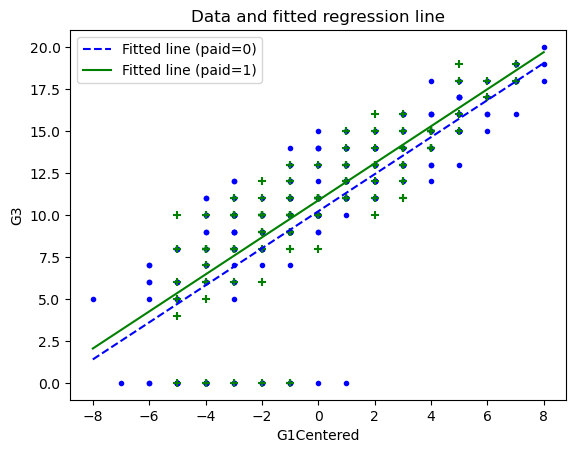

In [42]:
predictors = ["G1Centered","paid"]
outcome = "G3"
data = encoded_df.copy()
results_ = results_G1_paid_G3.copy()
linestyles = {0 : "--", 1: "-"}
c = {0 : "b", 1: "g"}
markers = {0 : ".", 1: "+"}

# Plot the data
for i in range(2):
    plt.scatter(data[data[predictors[1]]==i][predictors[0]], data[data[predictors[1]]==i][outcome], 
                color = c[i], 
                marker = markers[i])
    
x_domain = np.linspace(np.min(data[predictors[0]]), np.max(data[predictors[0]]), 100)


# Calculate the fitted values for two lines regarding the mom_hs
beta0_hat = results_.loc["Intercept"]["coef"]
beta1_hat = results_.loc[predictors[0]]["coef"]
beta2_hat = results_.loc[predictors[1]]["coef"]

fitted_values = [beta0_hat +  beta1_hat * x_domain  + beta2_hat * i for i in range(2)]


# Plot two fitted line
for i in range(2):
    plt.plot(x_domain, fitted_values[i], c = c[i], label = f"Fitted line (paid={i})", linestyle = linestyles[i])

# Add a legend and labels
plt.legend()
plt.ylabel(f"{outcome}")
plt.xlabel(f"{predictors[0]}")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

## Evaluating Model without Interaction 

In [43]:
results.rsquared

0.6473535005037385

The R squared for the model without interaction is around 0.6474. It explained 64.74 of variance of G3

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

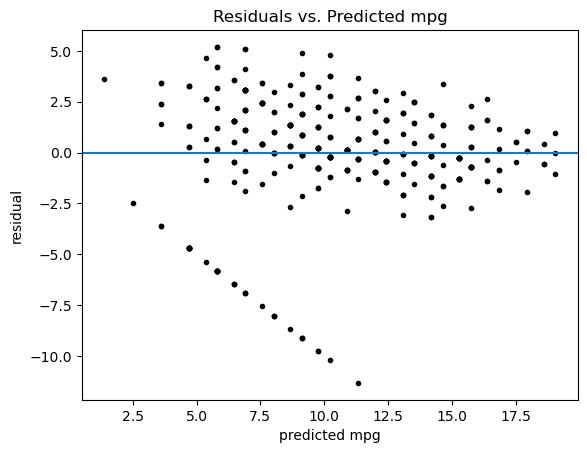

In [44]:
# Residual Plot and Explained Variance
plt.scatter(results.fittedvalues, results.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

## Regression With Interaction

In [45]:
# Create OLS model object
model = smf.ols('G3 ~ G1Centered + paid + G1Centered:paid', encoded_df)

# Fit the model
results_2 = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_G1_paid_inter_charges = print_coef_std_err(results_2)
results_G1_paid_inter_charges

,coef,std err
Intercept,10.227278,0.186541
G1Centered,1.147498,0.052256
paid,0.644323,0.275333
G1Centered:paid,-0.120809,0.085565


### G3 = 10.23 + 1.15 (G1 - 11) + 0.64 paid - 0.12 (G1 - 11)xpaid

#### Interpretasi

1. Jika paid bernilai 0 (tidak mengikuti les diluar kelas), maka estimasi selisih antara nilai siswa yang tidak mengikuti les namun memiliki nilai lebih tinggi 1 poin dari 11 saat kelas 1 adalah sebesar 1.15. Dan estimasi rata-rata nilai siswa adalah 10.23.
2. Jika paid bernilai 1(mengikuti les di luar kelas), maka estimasi selisih antara nilai siswa yang mengikuti les namun memiliki nilai lebih tinggi 1 poin dari 11 saat kelas 1 adalah 1.023. Dengan estimasi nilai rata-rata adalah 9.58.

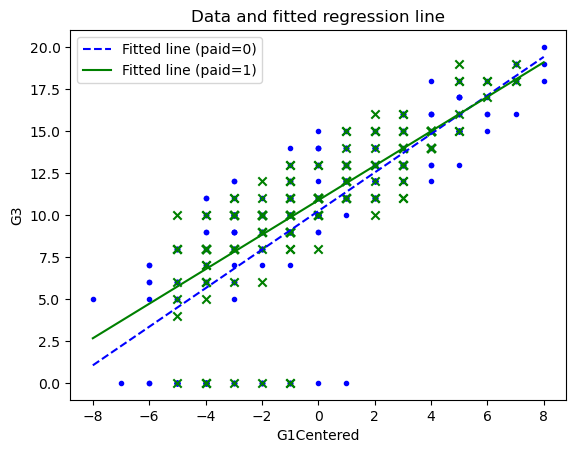

In [46]:
predictors = ["G1Centered", "paid", "G1Centered:paid"]
outcome = "G3"
data = encoded_df.copy()
results_ = results_G1_paid_inter_charges.copy()
linestyles = {0 : "--", 1: "-"}
c = {0 : "b", 1: "g"}
markers = {0 : ".", 1: "x"}

# Plot the data
for i in range(2):
    plt.scatter(data[data[predictors[1]]==i][predictors[0]], data[data[predictors[1]]==i][outcome], 
                color = c[i], marker = markers[i])

# Calculate the fitted values for two lines regarding the mom_hs
beta0_hat = results_.loc["Intercept"]["coef"]
beta1_hat = results_.loc[predictors[0]]["coef"]
beta2_hat = results_.loc[predictors[1]]["coef"]
beta3_hat = results_.loc[predictors[2]]["coef"]

fitted_values = [beta0_hat +  beta1_hat * x_domain  + beta2_hat * i + beta3_hat * i * x_domain for i in range(2)]

x_domain = np.linspace(np.min(data[predictors[0]]), np.max(data[predictors[0]]), 100)

# Plot two fitted line
for i in range(2):
    plt.plot(x_domain, fitted_values[i], c = c[i], label = f"Fitted line (paid={i})", linestyle = linestyles[i])

# Add a legend and labels
plt.legend()
plt.ylabel(f"{outcome}")
plt.xlabel(f"{predictors[0]}")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

## Evaluating Model with Interaction

In [47]:
results_2.rsquared

0.6491423293419689

The R squared for the model with interaction is around 0.6491. It explained 64.91 of variance of G3

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

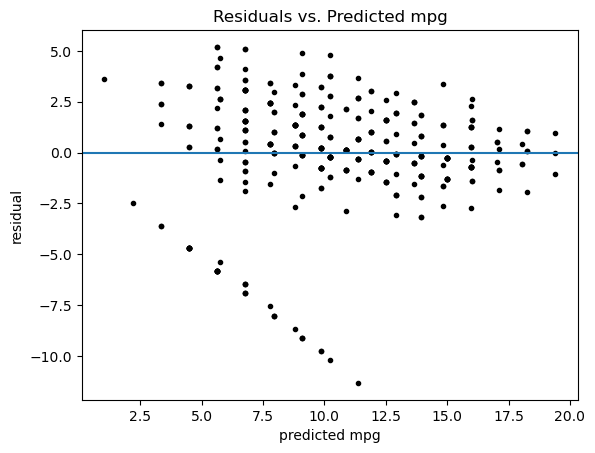

In [48]:
# Residual Plot and Explained Variance
plt.scatter(results_2.fittedvalues, results.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")